In [3]:
import os
import numpy as np
import glob
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:

from google.colab import files

# Upload ZIP file(s)
uploaded = files.upload()


Saving Audio_Speech_Actors_01-24.zip to Audio_Speech_Actors_01-24.zip
Saving Audio_Song_Actors_01-24.zip to Audio_Song_Actors_01-24.zip


In [4]:
import zipfile
import os

# Step 1: Define your zip files and target extraction paths
zip_files = {
    "Audio_Speech_Actors_01-24.zip": "data/Audio_Speech_Actors_01-24",
    "Audio_Song_Actors_01-24.zip": "data/Audio_Song_Actors_01-24"
}

# Step 2: Ensure 'data/' directory exists
os.makedirs("data", exist_ok=True)

# Step 3: Extract each zip to its respective folder
for zip_filename, extract_to in zip_files.items():
    if os.path.exists(zip_filename):
        print(f"📦 Extracting {zip_filename} to {extract_to} ...")
        os.makedirs(extract_to, exist_ok=True)
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"✅ Done extracting {zip_filename}")
    else:
        print(f"❌ Zip file not found: {zip_filename}")


📦 Extracting Audio_Speech_Actors_01-24.zip to data/Audio_Speech_Actors_01-24 ...
✅ Done extracting Audio_Speech_Actors_01-24.zip
📦 Extracting Audio_Song_Actors_01-24.zip to data/Audio_Song_Actors_01-24 ...
✅ Done extracting Audio_Song_Actors_01-24.zip


In [5]:
EMOTION_MAP = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# Reads files recursively from each actor's folder
import os

def get_ravdess_files(base_dir, selected_emotions):
    emotion_map = {
        1: "neutral",
        2: "calm",
        3: "happy",
        4: "sad",
        5: "angry",
        6: "fearful",
        7: "disgust",
        8: "surprised"
    }

    files = []
    labels = []

    for root, _, filenames in os.walk(base_dir):
        for filename in filenames:
            if filename.endswith(".wav"):
                try:
                    emotion_code = int(filename.split("-")[2])
                    emotion = emotion_map.get(emotion_code)
                    if emotion in selected_emotions:
                        files.append(os.path.join(root, filename))
                        labels.append(emotion)
                except:
                    continue

    print(f"✅ Loaded {len(files)} files from {base_dir}")
    return files, labels




In [14]:
def evaluate_model(model, X_test, y_test, label_names):
    loss, acc = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {acc:.2f}")

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))
import matplotlib.pyplot as plt

def plot_history(history, model=None, X_test=None, y_test=None, class_names=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    # Accuracy plot
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig("accuracy_plot.png")
    plt.show()
    plt.close()

    # Loss plot
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_plot.png")
    plt.show()
    plt.close()

    # Confusion Matrix
    if model is not None and X_test is not None and y_test is not None and class_names is not None:
        y_pred_probs = model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test, axis=1)

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.savefig("confusion_matrix.png")
        plt.show()
        plt.close()


In [54]:
# ... your imports ...

def augment_audio(file_path, sr=22050):
    y, _ = librosa.load(file_path, sr=sr)
    augmented = []

    # Add white noise
    noise = np.random.randn(len(y))
    y_noise = y + 0.005 * noise
    augmented.append(y_noise)

    # Pitch shift
    y_pitch = librosa.effects.pitch_shift(y, sr, n_steps=2)
    augmented.append(y_pitch)

    # Time stretch (speed up)
    y_fast = librosa.effects.time_stretch(y, rate=1.25)
    augmented.append(y_fast[:len(y)])

    # Time stretch (slow down)
    y_slow = librosa.effects.time_stretch(y, rate=0.8)
    if len(y_slow) > len(y):
        y_slow = y_slow[:len(y)]
    else:
        y_slow = np.pad(y_slow, (0, len(y) - len(y_slow)), 'constant')
    augmented.append(y_slow)

    return augmented

# ... rest of your code ...

def extract_features(file_path, sr=16000, n_mfcc=40):
    # Load audio
    audio, _ = librosa.load(file_path, sr=sr)

    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    # Transpose to shape (time_steps, n_mfcc)
    return mfcc.T


In [51]:
def train_model(model, X_train, y_train, epochs=50, batch_size=20):
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size)
    return history


In [9]:
import librosa
import numpy as np

def extract_features(file_path_or_bytes, sr=16000, n_mfcc=40):
    if isinstance(file_path_or_bytes, bytes):
        import io
        y, _ = librosa.load(io.BytesIO(file_path_or_bytes), sr=sr)
    else:
        y, _ = librosa.load(file_path_or_bytes, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    features = np.concatenate([mfcc, mfcc_delta, mfcc_delta2], axis=0)
    return features.T  # shape: (timesteps, n_features)


In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, Bidirectional
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="random_normal",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(1,),
                                 initializer="zeros",
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        e = K.tanh(K.dot(inputs, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = inputs * a
        return K.sum(output, axis=1)

def build_bilstm_attention_model(input_shape, num_classes):
    # Use None for time steps to allow variable-length input
    inputs = Input(shape=(None, input_shape[1]))
    x = Masking(mask_value=0.0)(inputs)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)
    x = AttentionLayer()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [82]:
import pandas as pd
import numpy as np
import librosa
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

# Feature extraction from raw audio signal
def extract_features_from_signal(signal, sr=22050):
    if len(signal) < 2048:
        return np.zeros((1, 40))
    try:
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
        return mfcc.T
    except Exception as e:
        print(f"⚠️ Feature extraction error: {e}")
        return np.zeros((1, 40))

# Extract features from file
def extract_features(file_path, sr=22050):
    try:
        y, _ = librosa.load(file_path, sr=sr)
        return extract_features_from_signal(y, sr)
    except Exception as e:
        print(f"⚠️ Feature extraction failed for {file_path}: {e}")
        return np.zeros((1, 40))

# Apply audio augmentations
def augment_audio(file_path):
    try:
        y, sr = librosa.load(file_path)
        return [
            librosa.effects.pitch_shift(y=y, sr=sr, n_steps=2),
            librosa.effects.time_stretch(y, rate=1.1),
            y + 0.005 * np.random.randn(len(y))  # add noise
        ]
    except Exception as e:
        print(f"⚠️ Augmentation error for {file_path}: {e}")
        return []

# Load and label dataset
SPEECH_DIR = "data/Audio_Speech_Actors_01-24"
SONG_DIR = "data/Audio_Song_Actors_01-24"
SELECTED_EMOTIONS = ["happy", "sad", "angry", "calm", "fearful", "disgust", "neutral"]

file_paths_speech, labels_speech = get_ravdess_files(SPEECH_DIR, SELECTED_EMOTIONS)
file_paths_song, labels_song = get_ravdess_files(SONG_DIR, SELECTED_EMOTIONS)

file_paths = file_paths_speech + file_paths_song
labels = labels_speech + labels_song

# DataFrame and split
df = pd.DataFrame({'file': file_paths, 'label': labels})
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Balance training set only
max_count = df_train['label'].value_counts().max()
df_train_balanced = df_train.groupby('label').apply(
    lambda x: resample(x, replace=True, n_samples=max_count, random_state=42)
).reset_index(drop=True)

# Extract and augment training features
print("🔄 Extracting & augmenting training features...")
X_train, y_train = [], []

for _, row in df_train_balanced.iterrows():
    path, label = row['file'], row['label']
    X_train.append(extract_features(path))
    y_train.append(label)

    for aug in augment_audio(path):
        X_train.append(extract_features_from_signal(aug))
        y_train.append(label)

# Extract test features (no augmentation)
print("🧪 Extracting test features...")
X_test = [extract_features(f) for f in df_test['file']]
y_test = df_test['label'].tolist()

# Pad sequences
X_train = pad_sequences(X_train, padding='post', dtype='float32')
X_test = pad_sequences(X_test, padding='post', dtype='float32')

# Flatten to 2D for scaling → then reshape back
original_shape_train = X_train.shape
original_shape_test = X_test.shape

scaler = StandardScaler()
X_train_2d = X_train.reshape(-1, X_train.shape[-1])
X_test_2d = X_test.reshape(-1, X_test.shape[-1])

X_train_2d = scaler.fit_transform(X_train_2d)
X_test_2d = scaler.transform(X_test_2d)

# Reshape back
X_train = X_train_2d.reshape(original_shape_train)
X_test = X_test_2d.reshape(original_shape_test)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_onehot = tf.keras.utils.to_categorical(y_train_encoded)
y_test_onehot = tf.keras.utils.to_categorical(y_test_encoded)

print("✅ Data prepared successfully!")


✅ Loaded 1440 files from data/Audio_Speech_Actors_01-24
✅ Loaded 1012 files from data/Audio_Song_Actors_01-24
🔄 Extracting & augmenting training features...


/tmp/ipython-input-82-3855993116.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_balanced = df_train.groupby('label').apply(


🧪 Extracting test features...
✅ Data prepared successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'attention_layer_9' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.2879 - loss: 1.7447 - val_accuracy: 0.0000e+00 - val_loss: 5.1429
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5336 - loss: 1.2361 - val_accuracy: 0.0000e+00 - val_loss: 6.3299
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6607 - loss: 0.9750 - val_accuracy: 0.0104 - val_loss: 6.6184
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.7088 - loss: 0.7964 - val_accuracy: 0.0368 - val_loss: 6.9752
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7615 - loss: 0.7054 - val_accuracy: 0.0560 - val_loss: 7.0734
Epoch 6/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.7953 - loss: 0.6017 - val_accuracy: 0.1064 - val_loss: 7.8165
Epoch 7/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8200 - loss: 0.5182 - val_accuracy: 0.1168 - val_loss: 8.3258
Epoch 8/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8257 - loss: 0.50

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


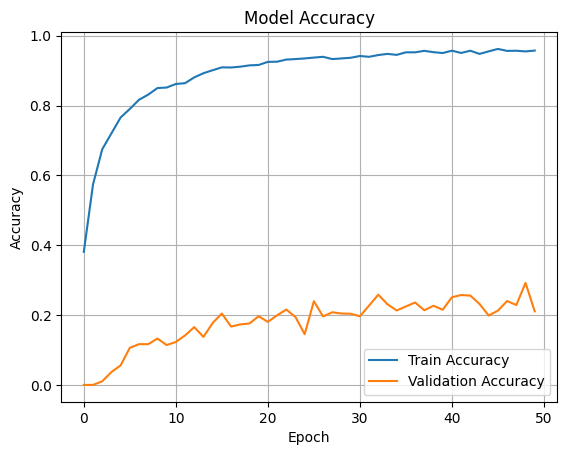

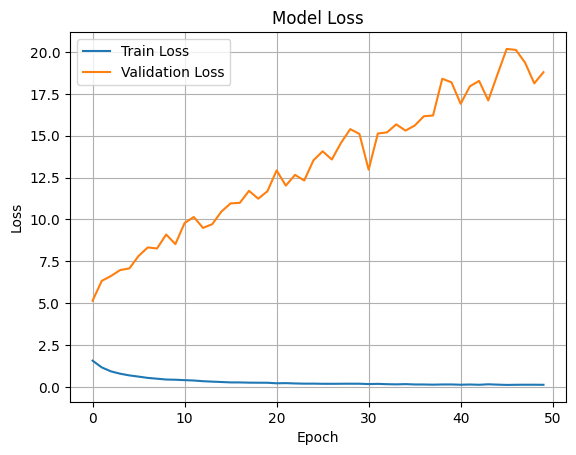

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


TypeError: object of type 'LabelEncoder' has no len()

<Figure size 1000x800 with 0 Axes>

In [53]:
# Build & Train
input_shape = X_train.shape[1:]
model = build_bilstm_attention_model(input_shape, len(label_encoder.classes_))
history = train_model(model, X_train, y_train_onehot)

# Evaluate
evaluate_model(model, X_test, y_test_onehot, label_encoder.classes_)
plot_history(history, model, X_test, y_test_onehot, label_encoder)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1015 - loss: 2.0869

Test Accuracy: 0.11
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.05      0.09      0.07        75
        calm       0.00      0.00      0.00        75
     disgust       0.00      0.00      0.00        39
     fearful       0.13      0.61      0.22        75
       happy       0.00      0.00      0.00        75
     neutral       0.00      0.00      0.00        38
         sad       0.00      0.00      0.00        75
   surprised       0.00      0.00      0.00        39

    accuracy                           0.11       491
   macro avg       0.02      0.09      0.04       491
weighted avg       0.03      0.11      0.04       491



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


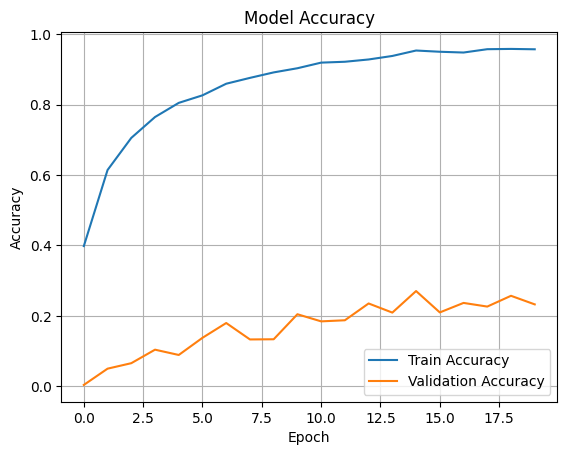

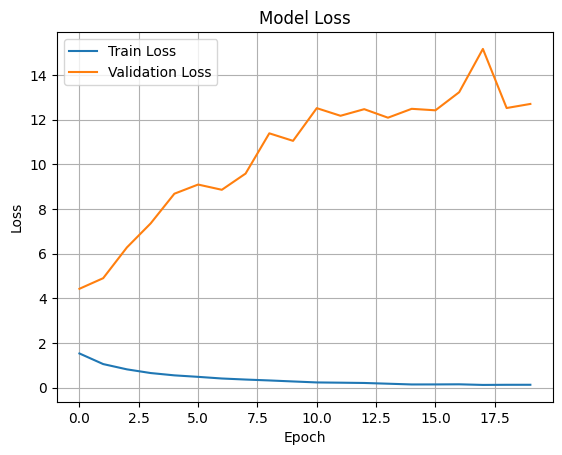

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


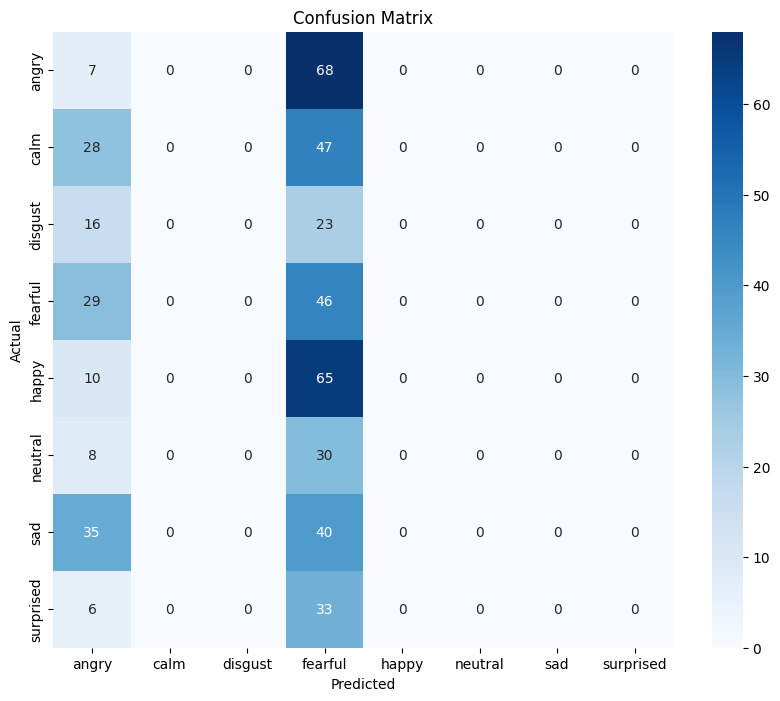

In [37]:
# Step 1: Pad sequences
X_train = pad_sequences(X_train, padding='post', dtype='float32')
X_test = pad_sequences(X_test, padding='post', dtype='float32')

# Step 2: Check shape and pass to model
input_shape = X_train.shape[1:]  # (timesteps, features)
model = build_bilstm_attention_model(input_shape, len(label_encoder.classes_))


In [24]:
print("X_test shape:", X_test.shape)


X_test shape: (491, 263, 40)


In [46]:
from collections import Counter
print("Train label distribution:", Counter(y_train))
print("Val label distribution:", Counter(y_test))


Train label distribution: Counter({'angry': 1204, 'calm': 1204, 'disgust': 1204, 'fearful': 1204, 'happy': 1204, 'neutral': 1204, 'sad': 1204, 'surprised': 1204})
Val label distribution: Counter({'fearful': 75, 'angry': 75, 'happy': 75, 'calm': 75, 'sad': 75, 'surprised': 39, 'disgust': 39, 'neutral': 38})


In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set fixed sequence length
MAX_LEN = 275

# Pad both training and test data
X_train = pad_sequences(X_train, maxlen=MAX_LEN, dtype='float32', padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=MAX_LEN, dtype='float32', padding='post', truncating='post')


In [28]:
inputs = Input(shape=(None, 40))  # instead of (275, 40)


In [41]:
print("y_train unique labels:", np.unique(y_train))
print("y_val unique labels:", np.unique(y_val))


y_train unique labels: ['angry']


NameError: name 'y_val' is not defined

In [43]:
from collections import Counter

print("All labels distribution:", Counter(y))


NameError: name 'y' is not defined

In [86]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Masking, BatchNormalization

def build_cnn_lstm_model(input_shape, num_classes):
    print("aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa")
    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=input_shape))

    # 📷 CNN layers
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # 🔁 LSTM
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))  # Added dropout after second LSTM
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.4))  # Added dropout after second LSTM

    # Fully connected
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [87]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

def train_model(model, X_train, y_train, epochs=50, batch_size=32):


    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,

    )
    return history


aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_23' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.1443 - loss: 1.9887 - val_accuracy: 0.0000e+00 - val_loss: 3.5833
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.1758 - loss: 1.9215 - val_accuracy: 0.0000e+00 - val_loss: 4.9049
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.2534 - loss: 1.7896 - val_accuracy: 0.0000e+00 - val_loss: 5.5538
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3298 - loss: 1.6134 - val_accuracy: 0.0000e+00 - val_loss: 6.7753
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3883 - loss: 1.4788 - val_accuracy: 0.0000e+00 - val_loss: 6.3733
Epoch 6/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4627 - loss: 1.3317 - val_accuracy: 0.0000e+00 - val_loss: 7.2239
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5359 - loss: 1.2059 - val_accuracy: 0.0000e+00 - val_loss: 8.0406
Epoch 8/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


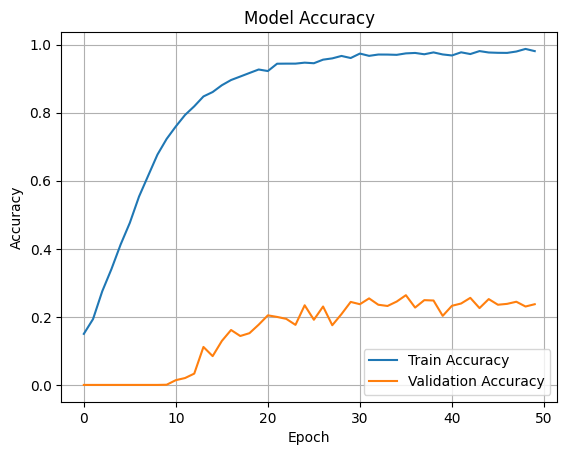

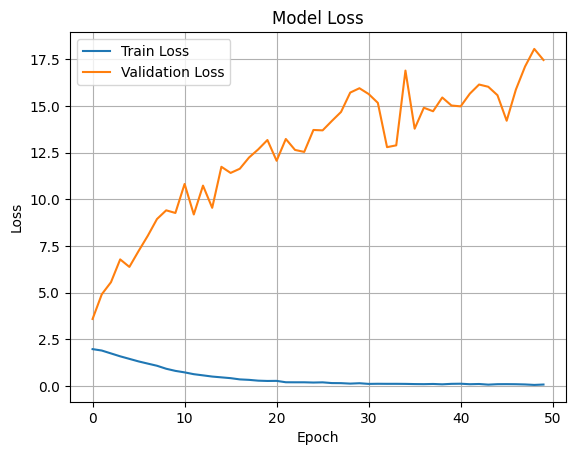

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


TypeError: object of type 'LabelEncoder' has no len()

<Figure size 1000x800 with 0 Axes>

In [88]:
# 🧠 Step 7: Build & Train Model
input_shape = X_train.shape[1:]
model = build_cnn_lstm_model(input_shape, len(label_encoder.classes_))
history = train_model(model, X_train, y_train_onehot)  # Early stopping now built-in

# 📊 Step 8: Evaluate & Plot
evaluate_model(model, X_test, y_test_onehot, label_encoder.classes_)
plot_history(history, model, X_test, y_test_onehot, label_encoder)

In [89]:
# Save model
model.save("emotion_model12.h5")
print("✅ Model saved as 'emotion_model.h5'")


✅ Model saved as 'emotion_model.h5'


In [90]:
import pickle

# Save label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("✅ Label encoder saved as 'label_encoder.pkl'")


✅ Label encoder saved as 'label_encoder.pkl'


In [91]:
from google.colab import files

# Download both files
files.download("emotion_model12.h5")
files.download("label_encoder.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>